# Used Car Auction Sales Data Analysis and Machine Learning

<hr>

<br>

Dataset for this project is https://www.kaggle.com/datasets/tunguz/used-car-auction-price


Used https://storage.googleapis.com/iamangelsh-public-datasets/car_prices.csv instead to make it easier for team to download based on the function **[def load_data](#Load-Data)**


Contributors for this Project:
- [Angel Santana Hernandez](https://github.com/iamAngelSH/Used_Car_Project/blob/main/Angel/modeling_angel.ipynb)
- [Liam Kennedy](https://github.com/iamAngelSH/Used_Car_Project/blob/main/Liam/Liam.ipynb)
- [Sarah Seibold](https://github.com/iamAngelSH/Used_Car_Project/blob/main/Sarah/Sarah.ipynb)
- [Prafulla Adusumalli](https://github.com/iamAngelSH/Used_Car_Project/blob/main/Prafulla/Prafulla%20-%20EDA.ipynb) 
- [Jerry Garcia](https://github.com/iamAngelSH/Used_Car_Project/tree/main/Jerry)

## Import Libraries

In [1]:
# IMPORT LIBRARIES
try:
    # PYSPARK
    from pyspark.sql import SparkSession
    from pyspark import SparkContext
    from pyspark.sql import SQLContext
    from pyspark.sql import DataFrame
    import pyspark.sql.types as tp
    import pyspark.sql.functions as F
    from pyspark.sql.functions import udf
    from pyspark.sql.types import DoubleType
    
    #Py Spark ML Libraries
    from pyspark.ml.regression import GBTRegressor
    from pyspark.ml.regression import LinearRegression
    from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler
    from pyspark.ml import Pipeline
    from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
    from pyspark.ml.evaluation import RegressionEvaluator
    from pyspark.mllib.stat import Statistics
    from pyspark.ml.feature import MinMaxScaler
    
    # OTHER LIBRARIES
    import pandas as pd
    import numpy as np
    import glob
    from functools import reduce
    import seaborn as sns
    import matplotlib.pyplot as plt
    from urllib.request import urlopen
    import datetime
    from pathlib import Path
    import six
    from datetime import datetime
    
    print('[SUCCESS]')

    #CATCH ERROR IMPORTING A LIBRARY
except ImportError as ie:
    raise ImportError(f'[Error importing]: {ie}')

[SUCCESS]


## Initializing Spark session and cluster for work enviornment

In [2]:
'''
INITIALIZING SPARK SESSION
- NAME IS SET FOR SPARK SESSION WHEN RUNNING ON LOCAL HOST
'''
# IF RUNNING ON DOCKER (LOCAL) 
spark = SparkSession.builder.master('local').config("spark.executor.memory", "1g").config("spark.driver.memory", "2g").appName('UsedCar_Project').getOrCreate()

# IF RUNNING ON AMAZON BUCKER (UNCOMMENT AND COMMENT THE TOP
# spark = SparkSession.builder.master('spark://spark-master:7077').config("spark.executor.memory", "1g").config("spark.driver.memory", "2g").appName('UsedCar_Project').getOrCreate()
print(f'[SUCCESSFULLY RUNNING SPARK SESSION] -- {datetime.now()}')

[SUCCESSFULLY RUNNING SPARK SESSION] -- 2022-04-25 15:18:13.338516


# Load Data

<hr>


Created by Angel

In [3]:
def load_data():
    '''
    car_prices.csv is uploaded to a google bucket for public use. Since file is too large to push to GitHub for others to use from repo
    this function will load the data from the google bucket.
    
    You can run this function each time and it will not download a new dataset each time since the first time you run it, it will download locally to your directory.
    --- unless you delete it each time
    
    Function will check to make sure file is in the directory
    - if it is, load it to a spark dataframe
    - if it is not, download it, then load it to a spark dataframe
    
    SCHEMA:
    - Created a schema to make sure the data types for the file being read is kept
    
    WARNING: TO USE THIS FUNCTION, YOU HAVE TO BE RUNNING JUPYTER NOTEBOOK ON A LINUX SERVER (USE DOCKER)
    
    NOTES:
    option("header",True).option("inferSchema", True)
    
    Auth: Angel S
    '''
    
    # CHECKS TO SEE IF FILE EXIST
    path = Path('car_prices.csv') 
    
    # IF FILE DOES NOT EXIST
    if not path.is_file():
        !wget https://storage.googleapis.com/iamangelsh-public-datasets/car_prices.csv 
    
    
    
    # CREATE SCHEMA TO KEEP DATA TYPES
    schema = tp.StructType([tp.StructField('year', tp.IntegerType(), True),
                           tp.StructField('make', tp.StringType(), True),
                           tp.StructField('model', tp.StringType(), True),
                           tp.StructField('trim', tp.StringType(), True),
                           tp.StructField('body', tp.StringType(), True),
                           tp.StructField('transmission', tp.StringType(), True),
                           tp.StructField('vin', tp.StringType(), True),
                           tp.StructField('state', tp.StringType(), True),
                           tp.StructField('condition', tp.DoubleType(), True),
                           tp.StructField('odometer', tp.DoubleType(), True),
                           tp.StructField('color', tp.StringType(), True),
                           tp.StructField('interior', tp.StringType(), True),
                           tp.StructField('seller', tp.StringType(), True),
                           tp.StructField('mmr', tp.IntegerType(), True),
                           tp.StructField('sellingprice', tp.IntegerType(), True),
                           tp.StructField('saledate', tp.StringType(), True)])
    
    
    # LOAD IN DATA WITH SCHEMA
    df = spark.read.csv("car_prices.csv", header = True, sep=",", schema=schema)
    
    old_df = df
    
    
    # FILTER OUT VIN NUMBERS FROM STATE COLUMN
    df = df.where(F.length(F.col("state")) <= 2)
    
    # DROP ROWS THAT CONTAIN NULL VALUES
    df = df.na.drop('any')
    
    # CREATE THRESHOLD FOR CONDITION COLUMN
    df = df.withColumn(
        'condition', 
        F.when(df.condition > 3.75, 'Great'
        ).when((df.condition >= 2) & (df.condition <= 3.75), 'Average'
        ).when(df.condition < 2, 'Bad'))
    
    # DROP COLUMNS THAT WON'T BE USED
    cols = ('trim', 'vin', 'interior', 'seller')
    df = df.drop(*cols)
    
    # USE MM DD YYYY FOR SALEDATE COLUMN
    df = df.withColumn(
        'saledate', F.substring('saledate', 5,11)
        ).withColumn(
        'saledate_year', F.substring('saledate', 7,5)
        ).withColumn(
        'saledate_month', F.substring('saledate', 1,3))
    
    df = df.withColumn(
        'saledate_year', F.col('saledate_year').cast(tp.IntegerType())
        )
    
    # RETURN NEW DATAFRAME
    return df, old_df


# LOAD THE DATA
df, old_df = load_data()

# SHOW DATA
df.show(5)

# SHOW NUMBER OF COLUMNS AND ROWS
print('Data for uncleaned DataFrame')
print(f'Number of columns: {len(old_df.columns)} \nNumber of Rows: {old_df.count()}')
print()
print('Data for cleaned DataFrame')
print(f'Number of columns: {len(df.columns)} \nNumber of Rows: {df.count()}')


# SHOW SCHEMA - DATATYPES
df.printSchema()

+----+-----+-------------------+-----+------------+-----+---------+--------+-----+-----+------------+-----------+-------------+--------------+
|year| make|              model| body|transmission|state|condition|odometer|color|  mmr|sellingprice|   saledate|saledate_year|saledate_month|
+----+-----+-------------------+-----+------------+-----+---------+--------+-----+-----+------------+-----------+-------------+--------------+
|2015|  Kia|            Sorento|  SUV|   automatic|   ca|    Great| 16639.0|white|20500|       21500|Dec 16 2014|         2014|           Dec|
|2015|  Kia|            Sorento|  SUV|   automatic|   ca|    Great|  9393.0|white|20800|       21500|Dec 16 2014|         2014|           Dec|
|2014|  BMW|           3 Series|Sedan|   automatic|   ca|    Great|  1331.0| gray|31900|       30000|Jan 15 2015|         2015|           Jan|
|2015|Volvo|                S60|Sedan|   automatic|   ca|    Great| 14282.0|white|27500|       27750|Jan 29 2015|         2015|           Jan|

# Preliminary Data Analysis

<hr>

## Null Values

Created by Angel

In [4]:
def null_values(df):
    '''
    TAKES IN A DATAFRAME AND RETURNS THE COUNT OF NULL VALUES IN EACH COLUMN
    
    Auth: Angel
    '''
    return df.agg(*[F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns])

NULL_VAL_COUNTS_OLD_DF = null_values(old_df)
NULL_VAL_COUNTS_OLD_DF.show()

print('After dropping Null values')
print()
NULL_VAL_COUNTS = null_values(df)
NULL_VAL_COUNTS.show()


+----+-----+-----+-----+-----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+
|year| make|model| trim| body|transmission|vin|state|condition|odometer|color|interior|seller|mmr|sellingprice|saledate|
+----+-----+-----+-----+-----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+
|   0|10301|10399|10651|13195|       65353|  4|    0|    11820|      94|  749|     749|     0| 26|           0|       0|
+----+-----+-----+-----+-----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+

After dropping Null values

+----+----+-----+----+------------+-----+---------+--------+-----+---+------------+--------+-------------+--------------+
|year|make|model|body|transmission|state|condition|odometer|color|mmr|sellingprice|saledate|saledate_year|saledate_month|
+----+----+-----+----+------------+-----+---------+--------+-----+---+------------+--------+-------------+--------------+


## Look for Outliers

Created by Liam

In [5]:
# CREATE A TEMPORARY VIEW TO QUERY
df.createOrReplaceTempView("usedCars")

# LOOK FOR OUTLIERS
spark.sql('select * from usedCars where sellingPrice = 1').show() # two records where sellingPrice = 1: these should be removed

spark.sql('select * from usedCars where odometer = 999999.0').show()
spark.sql('select count(*) as records from usedCars where odometer = 999999.0').show() # sixty records where odometer = 999,999.0; these should be removed

spark.sql('select * from usedCars where mmr < 100 order by mmr').show() # mmr values are significantly lower than sale date, but looks reasonable

spark.sql('select avg(mmr) as avg_mmr, avg(sellingprice) as avg_sellprice from usedCars').show() # mmr is about $140 higher than sale price


+----+-------------+------------+------------+------------+-----+---------+--------+-----+-----+------------+-----------+-------------+--------------+
|year|         make|       model|        body|transmission|state|condition|odometer|color|  mmr|sellingprice|   saledate|saledate_year|saledate_month|
+----+-------------+------------+------------+------------+-----+---------+--------+-----+-----+------------+-----------+-------------+--------------+
|2003|Mercedes-Benz|     E-Class|       Sedan|   automatic|   ga|  Average|     1.0|black| 7325|           1|Jan 06 2015|         2015|           Jan|
|2014|         Ford|E-Series Van|E-Series Van|   automatic|   tx|    Great| 31886.0|white|20800|           1|Feb 12 2015|         2015|           Feb|
+----+-------------+------------+------------+------------+-----+---------+--------+-----+-----+------------+-----------+-------------+--------------+

+----+---------+--------------+-------------+------------+-----+---------+--------+------+---

In [6]:
def filter_outliers(df):
    '''
    FUNCTION TAKES IN 1 PARAMETER
    
    PARAM 1 --> Dataframe to adjust
    
    Will return a new dataframe without the outliers
    
    Auth: Liam
    '''
    
    # FILTER OUT SELLINGPRICE = 1 AND ODOMETER = 999999.0
    df = df.where(F.col("sellingprice") != 1)
    df = df.where(F.col("odometer") != 999999.0)
    
    return df

df = filter_outliers(df)

## Scale Continous Variables

Created by Liam

In [7]:
'''
Auth: Liam
'''
# UDF for converting column type from vector to double type
unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())

# Iterating over columns to be scaled
for i in ["year", "odometer", "sellingprice"]:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    df = pipeline.fit(df).transform(df).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")

print("Scaled Dataframe:")
df.show(5)


Scaled Dataframe:
+----+-----+-------------------+-----+------------+-----+---------+--------+-----+-----+------------+-----------+-------------+--------------+-----------+---------------+-------------------+
|year| make|              model| body|transmission|state|condition|odometer|color|  mmr|sellingprice|   saledate|saledate_year|saledate_month|year_Scaled|odometer_Scaled|sellingprice_Scaled|
+----+-----+-------------------+-----+------------+-----+---------+--------+-----+-----+------------+-----------+-------------+--------------+-----------+---------------+-------------------+
|2015|  Kia|            Sorento|  SUV|   automatic|   ca|    Great| 16639.0|white|20500|       21500|Dec 16 2014|         2014|           Dec|        1.0|          0.017|              0.093|
|2015|  Kia|            Sorento|  SUV|   automatic|   ca|    Great|  9393.0|white|20800|       21500|Dec 16 2014|         2014|           Dec|        1.0|           0.01|              0.093|
|2014|  BMW|           3 Se

## Look for Clusters

Created by Liam

In [13]:
def sql_query_clusters(df):
    '''
    AuthL Liam
    '''
    
    # CREATE A TEMPORARY VIEW TO QUERY
    df.createOrReplaceTempView("usedCars")

    spark.sql('select make, avg(sellingprice) as avg_price from usedCars group by make order by avg_price desc').show()

    spark.sql('select make, model, avg(sellingprice) as avg_price from usedCars group by make, model order by avg_price desc').show() # make-model looks promising, maybe quartiles?
    
sql_query_clusters(df)

+-------------+------------------+
|         make|         avg_price|
+-------------+------------------+
|  Rolls-Royce|         153456.25|
|      Ferrari|128852.94117647059|
|  Lamborghini|          111500.0|
|      Bentley| 72713.33333333333|
|        Tesla| 67054.34782608696|
| Aston Martin|           55500.0|
|       Fisker| 46461.11111111111|
|     Maserati| 43729.81651376147|
|        Lotus|           40800.0|
|      Porsche|38932.109766637856|
|   Land Rover| 33225.28744326778|
|          Ram|25257.458209693374|
|Mercedes-Benz|21320.646172522138|
|          BMW|21293.283902661944|
|     Infiniti| 20562.79630290486|
|        Lexus|20286.116929285166|
|         Audi|20010.167638483967|
|       Jaguar|19429.853619729514|
|      Lincoln| 17547.19143321153|
|          GMC| 16769.46783118151|
+-------------+------------------+
only showing top 20 rows

+-------------+--------------------+------------------+
|         make|               model|         avg_price|
+-------------+-------

# Exploratory Data Analysis

<hr>

In [5]:
def plot_basic_visuals(df, col_name: str):
    '''
    Parameters:
    - PySpark Dataframe with only 2 columns
    - Column name that we want to plot (as a string)
    
    Uses:
    - Function will select desired column, group by column and count each type
    - Function will convert PySpark Dataframe into a Pandas Dataframe
    - Will then plot x and y 
    
    Auth: Angel
    '''
    df = df.select([col_name]).groupBy(col_name).count()
    pandas_df = df.toPandas()
    pandas_df.plot(kind='bar', x=pandas_df.columns[0], y=pandas_df.columns[1], colormap='winter_r', figsize=(20,6))
    
    


**Visuals on Columns by count and type**

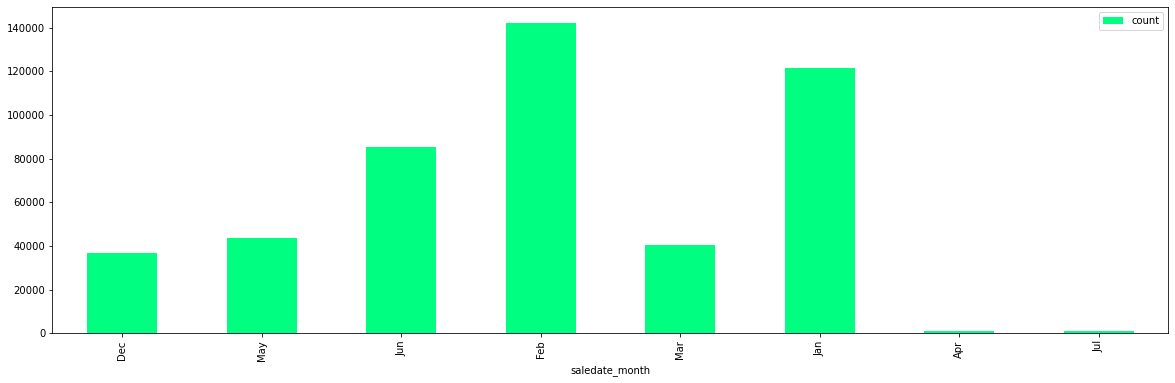

In [6]:
plot_basic_visuals(df, 'saledate_month')

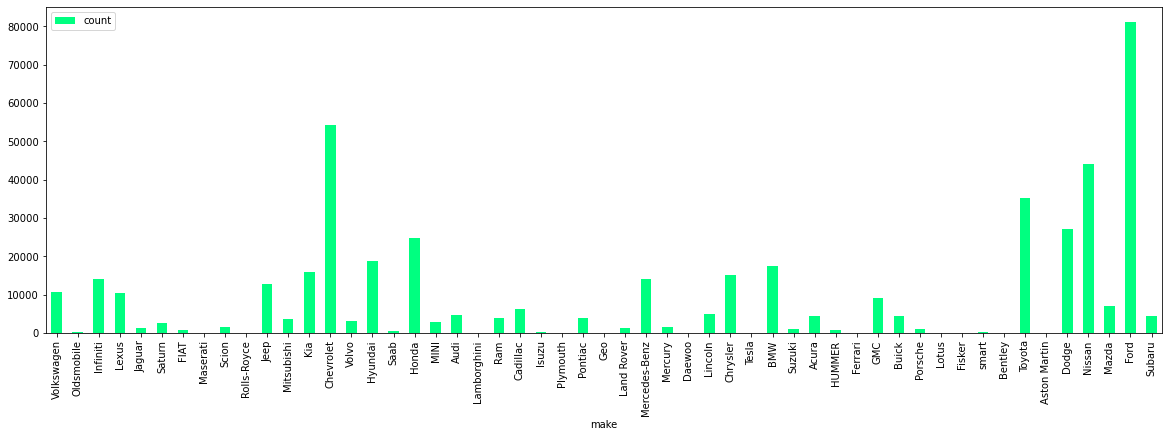

In [95]:
plot_basic_visuals(df, 'make')

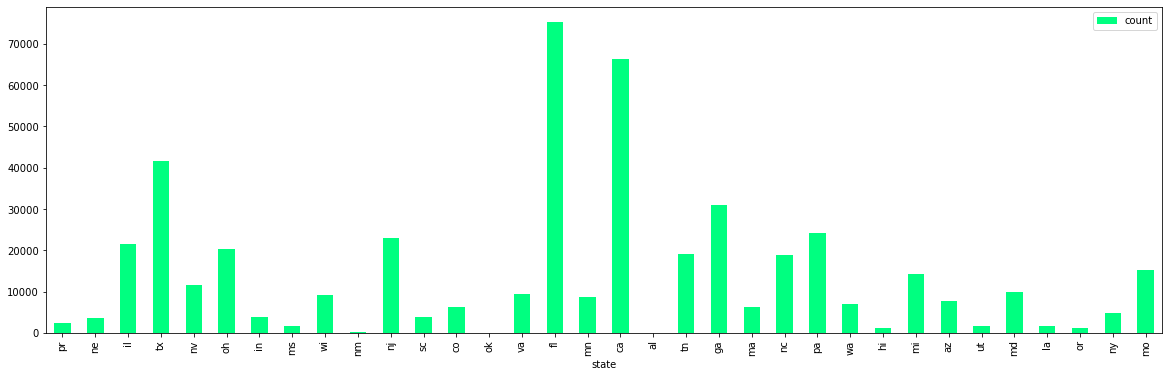

In [96]:
plot_basic_visuals(df, 'state')

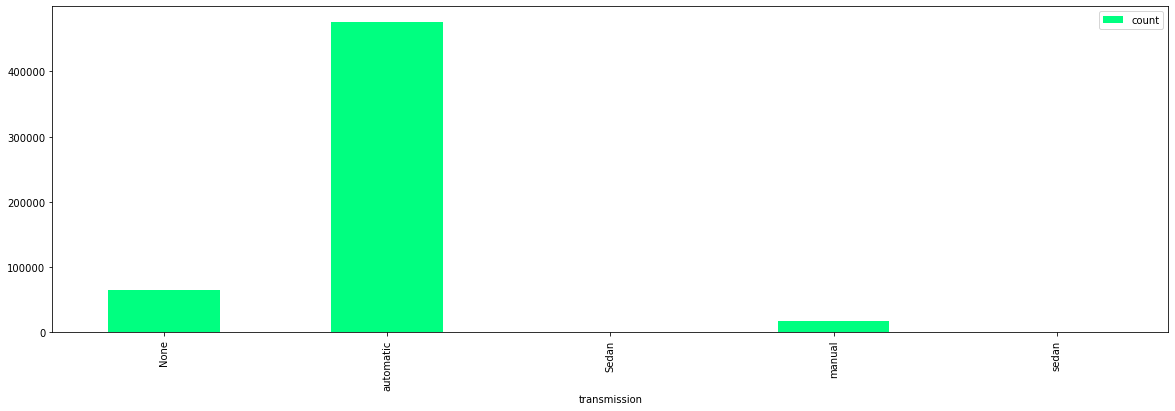

In [25]:
plot_basic_visuals(df, 'transmission')

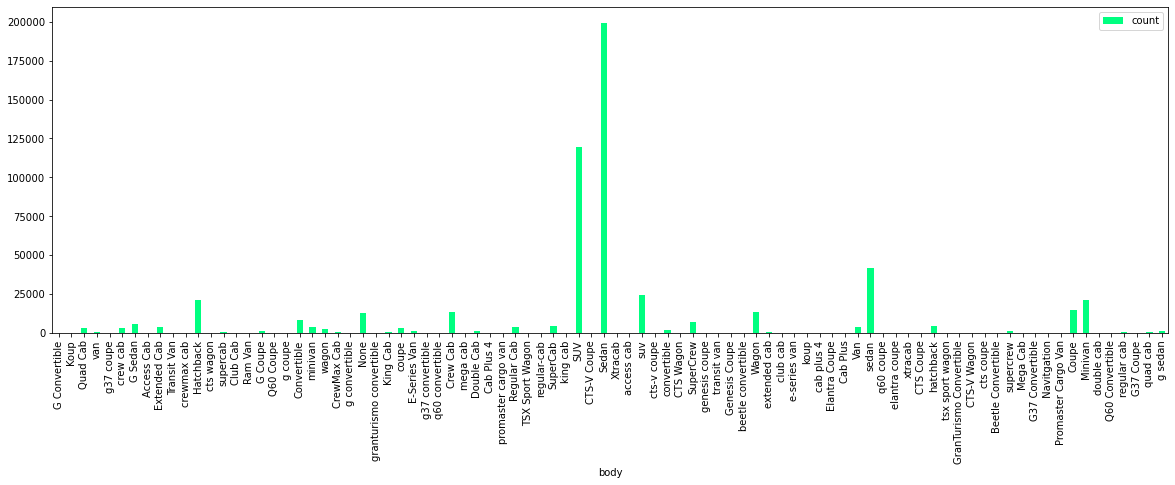

In [26]:
plot_basic_visuals(df, 'body')

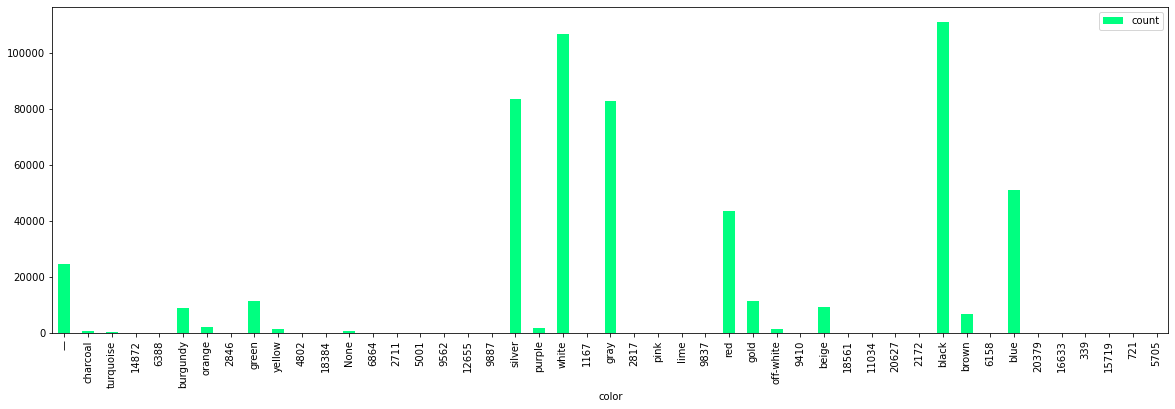

In [27]:
plot_basic_visuals(df, 'color')

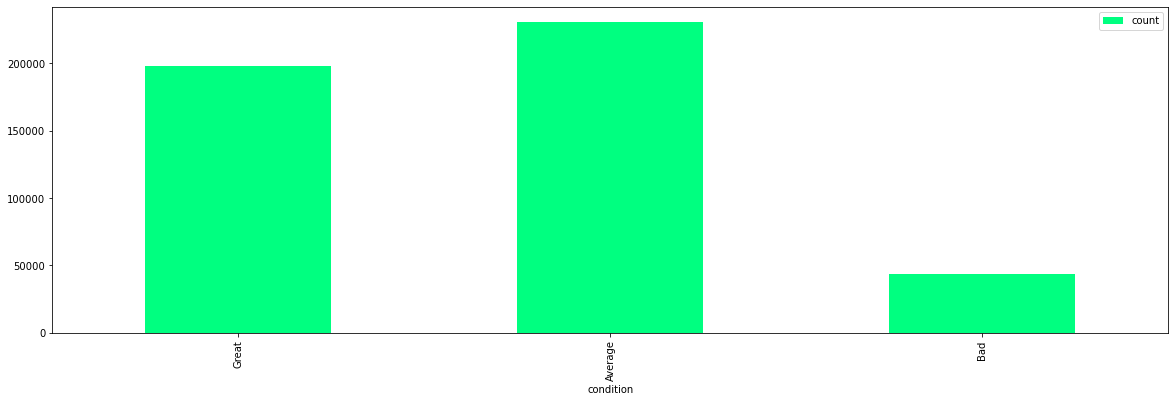

In [97]:
plot_basic_visuals(df, 'condition')

In [8]:
def describe_df(df):
    '''
    Auth: Sarah
    '''
    return df.describe().toPandas().head()

describe_df(df)

,summary,year,make,model,body,transmission,state,condition,odometer,color,mmr,sellingprice,saledate,saledate_year,saledate_month
0,count,472274,472274,472274,472274,472274,472274,472274,472274,472274,472274,472274,472274,472274,472274
1,mean,2010.2115636262001,None,794.7396490032373,None,None,None,None,66582.71421674706,None,13838.284131669328,13691.96701702825,None,2014.9221151280824,None
2,stddev,3.8217253857145166,None,809.0107198011169,None,None,None,None,50865.95005493663,None,9531.935882664848,9612.609439836551,None,0.26799061683907843,None
3,min,1990,Acura,1 Series,Access Cab,automatic,al,Average,1.0,beige,25,100,Apr 01 2015,2014,Apr
4,max,2015,smart,xD,xtracab,manual,wi,Great,980113.0,—,182000,230000,May 31 2015,2015,May


In [9]:
def sql_queries(df):
    '''Auth: Sarah'''
    
    df.createOrReplaceTempView("df")
    
    # Query 1:
    spark.sql("select make, count(sellingprice) from df group by make order by count(sellingprice) desc").show(10)
    
    # Query 2
    spark.sql("select make, avg(sellingprice) from df group by make order by avg(sellingprice) desc").show()
    
    # Query 3
    spark.sql("select model, avg(sellingprice) from df group by model order by avg(sellingprice) desc").show(5)
    
    #Query 4
    spark.sql("select state, avg(sellingprice) from df group by state order by avg(sellingprice) desc").show()
    
    # Query 5
    spark.sql("select saledate_month, avg(sellingprice) from df group by saledate_month order by avg(sellingprice) desc").show()
    
    # Query 6
    spark.sql("select color, avg(sellingprice) from df group by color order by avg(sellingprice) desc").show()
    
    # Query 7
    spark.sql("select transmission, avg(sellingprice) from df group by transmission order by avg(sellingprice) desc").show()
    
    
    
sql_queries(df)

+---------+-------------------+
|     make|count(sellingprice)|
+---------+-------------------+
|     Ford|              81003|
|Chevrolet|              54141|
|   Nissan|              44037|
|   Toyota|              35312|
|    Dodge|              27178|
|    Honda|              24781|
|  Hyundai|              18659|
|      BMW|              17506|
|      Kia|              15825|
| Chrysler|              15133|
+---------+-------------------+
only showing top 10 rows

+-------------+------------------+
|         make| avg(sellingprice)|
+-------------+------------------+
|  Rolls-Royce|         153456.25|
|      Ferrari|128852.94117647059|
|  Lamborghini|          111500.0|
|      Bentley| 72713.33333333333|
|        Tesla| 67054.34782608696|
| Aston Martin|           55500.0|
|       Fisker| 46461.11111111111|
|     Maserati| 43729.81651376147|
|        Lotus|           40800.0|
|      Porsche|38932.109766637856|
|   Land Rover| 33225.28744326778|
|          Ram|25257.458209693374|
|

In [10]:
sns.set(color_codes=True)
%matplotlib inline
df.head()
pandas_df = df.toPandas()

<AxesSubplot:>

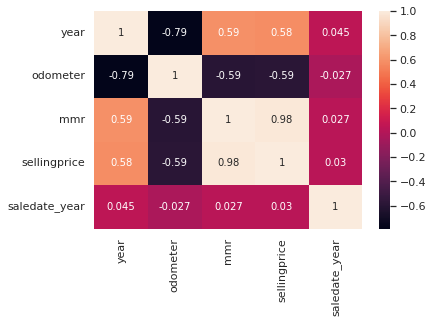

In [11]:
# Uses a heat map to represenet the same correlations -- Jerry
sns.heatmap(pandas_df.corr(), annot=True)

<AxesSubplot:xlabel='sellingprice', ylabel='Count'>

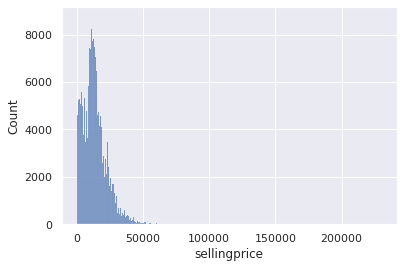

In [12]:
# Plot selling price information -- Jerry
sns.histplot(pandas_df.sellingprice)

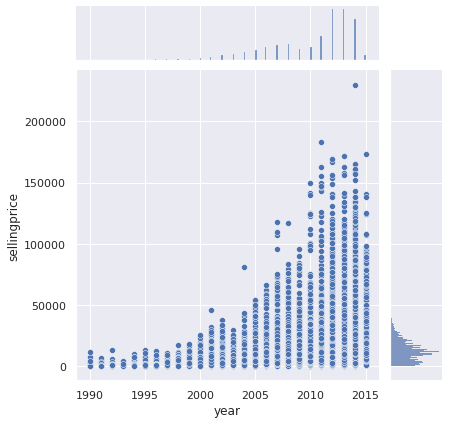

In [13]:
# Year and selling price have a good correlation -- Jerry
# Plot a graph using those 2 features.
sns.jointplot(data = pandas_df, x = 'year', y = 'sellingprice')

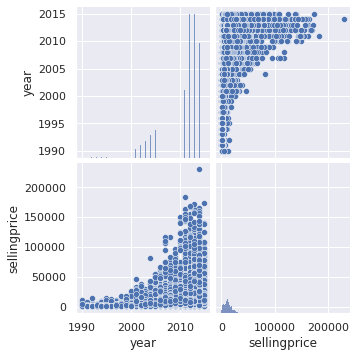

In [14]:
# Pairplot using year and selling price -- Jerry
sns.pairplot(pandas_df[['year','sellingprice']])

<AxesSubplot:xlabel='year', ylabel='sellingprice'>

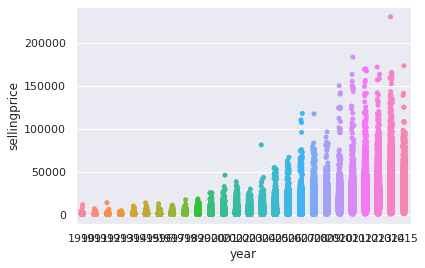

In [15]:
# -- Jerry
sns.stripplot(data = pandas_df, x = 'year', y = 'sellingprice', jitter=True)

<AxesSubplot:xlabel='year', ylabel='sellingprice'>

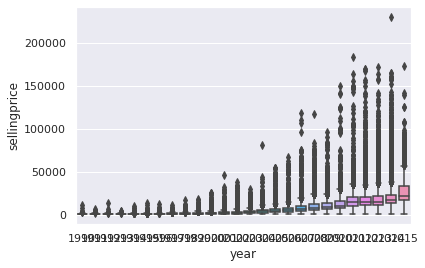

In [16]:
# Using a blox plot to see if there are any outliers, we can see at least one. -- Jerry
sns.boxplot(data = pandas_df, x = 'year', y = 'sellingprice')

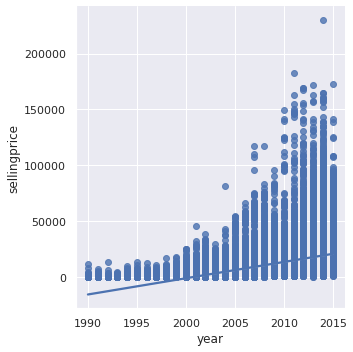

In [17]:
# Plot a linear regression graph -- Jerry
sns.lmplot(y='sellingprice',x='year', data=pandas_df)

<AxesSubplot:>

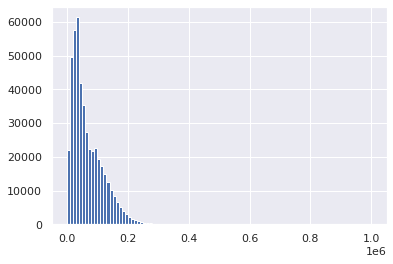

In [13]:
# -- Prafulla
pandas_df['odometer'].hist(bins=100)

<AxesSubplot:>

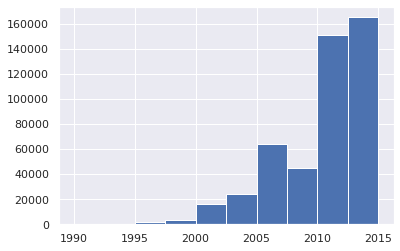

In [18]:
# -- Prafulla
pandas_df['year'].hist(bins=10)

<AxesSubplot:>

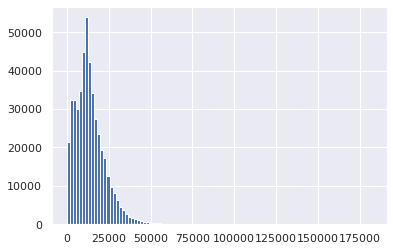

In [15]:
# -- Prafulla
pandas_df['mmr'].hist(bins=100)

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mmr', ylabel='Density'>

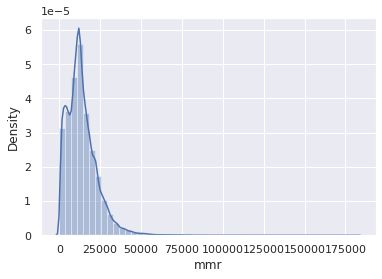

In [19]:
# -- Prafulla
sns.distplot(pandas_df['mmr'])

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='odometer', ylabel='Density'>

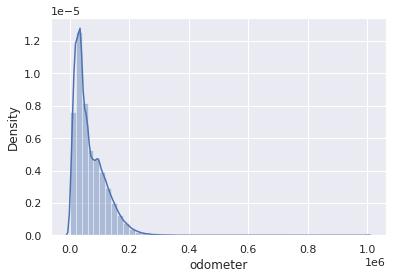

In [42]:
# -- Prafulla
sns.distplot(pandas_df['odometer'])

<AxesSubplot:>

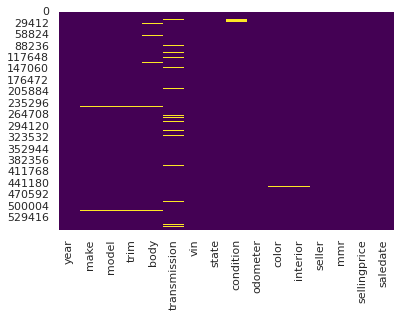

In [29]:
# -- Prafulla
sns.heatmap(old_df.isnull(),cbar=False,cmap='viridis')

<AxesSubplot:xlabel='sellingprice', ylabel='transmission'>

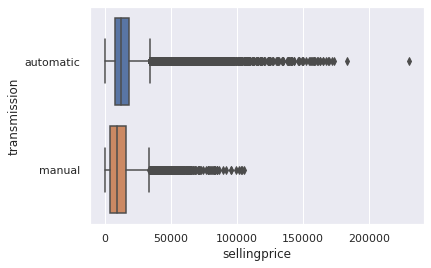

In [32]:
# -- Prafulla
sns.boxplot(x='sellingprice',y='transmission',data=pandas_df)

<AxesSubplot:xlabel='sellingprice', ylabel='condition'>

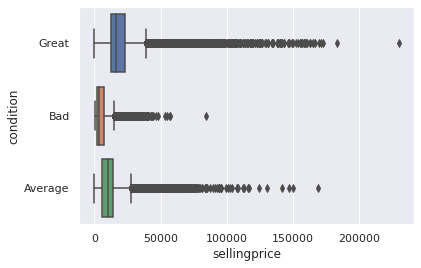

In [33]:
# -- Prafulla
sns.boxplot(x='sellingprice',y='condition',data=pandas_df)

<AxesSubplot:xlabel='sellingprice', ylabel='color'>

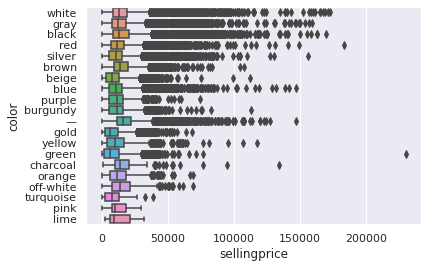

In [36]:
# -- Prafulla
sns.boxplot(x='sellingprice',y='color',data=pandas_df)

# Modeling and Predictions
<hr>

Created by Angel

In [9]:
def data_processing(df):
    '''
    FUNCTION TAKES IN 2 PARAMETERS:
    1. Data Frame --> data frame that you are working with that you want to process
    2. Column Names --> these are the categorical columns that will be used for processing/transformed
    
    Methods applied:
    1. Indexing --> Get index of string columns
    2. One hot encoding --> categorical values to numerical values
    3. Assembler --> vectorizing encoded values
    4. Pipeline --> create a pipeline do bring all these processes together
    
    Returns a transformed model as a dataframe
    
    Auth: Angel
    '''
    
    # 1. INDEXER
    
    cc = names = ['year', 'make', 'model', 'body', 'transmission', 'state', 'condition',
       'odometer', 'color', 'mmr', 'saledate', 'saledate_year',
       'saledate_month', 'year_Scaled', 'odometer_Scaled',
       'sellingprice_Scaled']
    indexers = [StringIndexer(inputCol = column, outputCol = f'{column}_indexed') for column in cc]
    
    # 2. One Hot Encoding
    
    encoders = [OneHotEncoder(dropLast = False, inputCol = idx.getOutputCol(), outputCol = f'{idx.getOutputCol()}_encoded') for idx in indexers]
    
    # 3. Assembler --> Vectorize encoded values
    
    assembler = VectorAssembler(inputCols = [encoded_val.getOutputCol() for encoded_val in encoders], outputCol = 'features')
    
    # 4. Pipeline
    
    pipeline = Pipeline(stages = indexers + encoders + [assembler])
    
    
    # Return our transformed moder
    model = pipeline.fit(df)
    
    transformed_df = model.transform(df)
    
    return transformed_df


trans_df = data_processing(df)
# trans_df.printSchema()
trans_df = trans_df.select(['features', 'sellingprice'])

In [10]:
def train_test_split(df, split):
    '''
    FUNCTION TAKES IN 2 PARAMETERS:
    1. DATAFRAME --> Dataframe that will be split (the one from above that was transformed)
    2. SPLITS --> list with split1 and split 2 (ex: 0.7, 0.3)
    
    RETURN:
    - train_df : split[0]
    - test_df : split[1]
    
    Auth: Angel
    '''
    
    splits = df.randomSplit(split)
    
    return splits[0], splits[1]


split_list = [0.7, 0.3]
df_train, df_test = train_test_split(trans_df, split_list)

In [11]:
def create_linear_reg_model(train, test):
    '''
    FUNCTION TAKES IN 2 PARAMETERS AND RETURNS A LINEAR MODEL
    
    PARAM 1 --> TRAIN dataset
    PARAM 2 --> TEST dataset
    
    
    OVERVIEW:
    Function will create a linear regression model and print RMSE and r2.
    It will aslo return the linear regression model for predictions
    
    Auth: Angel
    '''
    
    lr_model = LinearRegression(
        featuresCol = 'features',
        labelCol = 'sellingprice',
        maxIter = 10,
        regParam = 0.3,
        elasticNetParam = 0.8
    )
    
    linear_model = lr_model.fit(train)
    
    trainSummary = linear_model.summary
    print(
        f'RMSE: {round(trainSummary.rootMeanSquaredError, 2)}'
    )
    print(
        f'r2: {round(trainSummary.r2, 2)}'
    )
    
    return linear_model
    
linear_model = create_linear_reg_model(df_train, df_test)

RMSE: 828.34
r2: 0.99


In [12]:
def create_grad_boost_tree_model(train, test):
    '''
    FUNCTION TAKES IN 2 PARAMETERS AND RETURNS A GRADIENT BOOSTED TREE REGRESSION MODEL
    
    PARAM 1 --> TRAIN dataset
    PARAM 2 --> TEST dataset
    
    
    OVERVIEW:
    Function will create a linear regression model and print RMSE and r2.
    It will aslo return the linear regression model for predictions
    
    Auth: Angel
    '''
    
    gbt_model = GBTRegressor(
        fearturesCol = 'features',
        labelCol = 'sellingprice',
        maxIter = 10
    )
    
    
    gradientBoost_model = gbt_model.fit(train)
    
    trainSummary = gradientBoost_model.summary
    print(
        f'RMSE: {round(trainSummary.rootMeanSquaredError, 2)}'
    )
    print(
        f'r2: {round(trainSummary.r2, 2)}'
    )
    return gradientBoost_model


gbtr_model = create_linear_reg_model(df_train, df_test)

RMSE: 828.34
r2: 0.99


In [13]:
def make_predictions(model, test, model_name):
    '''
    FUNCTION TAKES IN 2 PARAMETERS
    
    PARAM 1 -- Model created
    PARAM 2 -- test dataset
    
    OVERVIEW:
    Function will create predictions and will evaluate the predictions for R2 and RMSE
    
    Will return a predictions dataframe
    
    Auth: Angel
    '''
    
    predictions = model.transform(test)
    
    model_eval = RegressionEvaluator(
        predictionCol = 'prediction',
        labelCol = 'sellingprice',
        metricName = 'r2')
    modelEval = model.evaluate(test)
    
    
    print(f'Stats for {model_name}:')
    print(f'R2 on test data: {model_eval.evaluate(predictions)}')
    print(f'RMSE on test data: {modelEval.rootMeanSquaredError}')

    
    return predictions


In [14]:
linear_model_predictions = make_predictions(linear_model, df_test, 'Linear Model')

Stats for Linear Model:
R2 on test data: 0.9670207067914722
RMSE on test data: 1745.0047891975328


In [15]:
# Look at the predictions
linear_model_predictions.select('prediction', 'sellingprice').show()

+------------------+------------+
|        prediction|sellingprice|
+------------------+------------+
|12129.930655416621|       12500|
|12449.403801202146|       12100|
|12097.969528087966|       12800|
|14651.167747928943|       16200|
|16534.066735641274|       16500|
|12056.846147881643|       12400|
| 9814.807350525416|       10500|
| 11259.70977052601|       11700|
|11603.970744888204|       12100|
|10120.288250249478|       10800|
|11918.359711929044|       11100|
|13432.307940005765|       11700|
|11584.319721003709|       12700|
|  10387.0224722341|       10500|
|14693.864806039412|       14600|
|15029.879613574052|       15000|
|14063.778366027269|       15100|
| 19533.39045728939|       20800|
|13381.470708635441|       13800|
|  15601.7328254291|       15600|
+------------------+------------+
only showing top 20 rows



In [16]:
gbtr_model_predictions = make_predictions(gbtr_model, df_test, 'Gradient Boosted Tree Regressor')

Stats for Gradient Boosted Tree Regressor:
R2 on test data: 0.9670207067914722
RMSE on test data: 1745.0047891975328


In [17]:
gbtr_model_predictions.select('prediction', 'sellingprice').show()

+------------------+------------+
|        prediction|sellingprice|
+------------------+------------+
|12129.930655416621|       12500|
|12449.403801202146|       12100|
|12097.969528087966|       12800|
|14651.167747928943|       16200|
|16534.066735641274|       16500|
|12056.846147881643|       12400|
| 9814.807350525416|       10500|
| 11259.70977052601|       11700|
|11603.970744888204|       12100|
|10120.288250249478|       10800|
|11918.359711929044|       11100|
|13432.307940005765|       11700|
|11584.319721003709|       12700|
|  10387.0224722341|       10500|
|14693.864806039412|       14600|
|15029.879613574052|       15000|
|14063.778366027269|       15100|
| 19533.39045728939|       20800|
|13381.470708635441|       13800|
|  15601.7328254291|       15600|
+------------------+------------+
only showing top 20 rows

